# <center> Graph and Activity stats from dataset

Imports.

In [1]:
import os
import util
from time import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Choose dataset and edit `out_path`. <b> Attention ! </b> Si `truegraph` la liste d'adjacence doit être au format $leader follower$.

In [71]:
dataset = 'weibo_T'
cascade = False

data_path, RTU, truegraph = util.load_data(dataset)
if RTU : 
    cascade = False # en cas d'erreur d'inattention
out_path = "../DataAnalysis/{}/".format(dataset)
if cascade:
    out_path = out_path[:-1] + "_cascade/" 

Open outfile (and create out folder if necessary).

In [73]:
try:
    graph_stats = open(out_path + "/graph_stats.txt", 'w')
except FileNotFoundError:
    os.mkdir(out_path)
    graph_stats = open(out_path + "/graph_stats.txt", 'w')

Author dict creation.

In [76]:
if truegraph:
    Author = None
else:
    Author = util.get_authors(data_path)

### Graph construction
Construit un graphe nx à partir du dataset.

In [77]:
G = util.get_nx_graph(data_path, RTU, cascade, truegraph, Author)

KeyboardInterrupt: 

### Basic stats

In [57]:
%%capture cap
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

In [58]:
print(cap)
graph_stats.write(cap.stdout+'\n')

Number of nodes: 1340816
Number of edges: 26294030



52

### Degrees stats

Les degrés.

In [59]:
deg = {'degrees': [x[1] for x in G.degree()], 
       'in_degrees': [x[1] for x in G.in_degree()],
       'out_degrees': [x[1] for x in G.out_degree()]}

Calcul des stats.

In [60]:
%%capture cap

for d_type in deg.keys():
    d = deg[d_type]
    print("----- Stats for {} -----".format(d_type))
    print("Mean: ", np.mean(d))
    print("Median: ", np.median(d))
    print("Min: ", np.min(d))
    print("Max: ", np.max(d))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(d, percent)))
    print()

Print and save.

In [61]:
print(cap)
graph_stats.write(cap.stdout+'\n')

----- Stats for degrees -----
Mean:  39.22093710098925
Median:  15.0
Min:  1
Max:  455506
25% <= 5.0
75% <= 29.0
90% <= 46.0
95% <= 60.0
99% <= 108.0

----- Stats for in_degrees -----
Mean:  19.610468550494623
Median:  14.0
Min:  0
Max:  291
25% <= 5.0
75% <= 29.0
90% <= 44.0
95% <= 56.0
99% <= 83.0

----- Stats for out_degrees -----
Mean:  19.610468550494623
Median:  0.0
Min:  0
Max:  455504
25% <= 0.0
75% <= 0.0
90% <= 0.0
95% <= 0.0
99% <= 46.0




454

### Degrees distribution
On affiche et on enregistre la distribution des degrés.

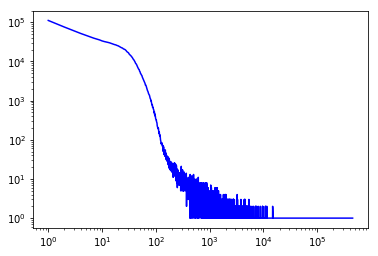

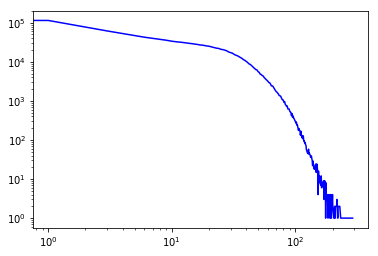

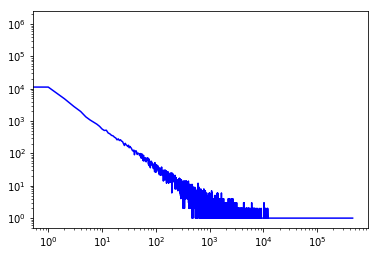

In [62]:
for d_type in deg.keys():
    
    # on récupère les degrés
    d = np.array(sorted(deg[d_type]))
    
    # on compte les occurences
    nb_occ = np.bincount(d)
    nb_occ = nb_occ[nb_occ > 0]

    # on récupère les valeurs uniques de d
    d = np.unique(d)

    # plot
    plt.loglog(d, nb_occ, color='blue')
    
    # save & show
    plt.savefig(out_path + d_type + "_distrib_log.pdf")
    plt.show()
    plt.close()

### Connected components basic stats

In [63]:
%%capture cap

start = time()
cc_sizes = {'weakly': [len(c) for c in nx.weakly_connected_components(G)],
            'strongly': [len(c) for c in nx.strongly_connected_components(G)]}

print("Number of weakly connected components: {} (calculated in {})"
      .format(len(cc_sizes['weakly']), time()-start))
print("Number of strongly connected components: {} (calculated in {})"
      .format(len(cc_sizes['strongly']), time()-start))

In [64]:
print(cap)
graph_stats.write(cap.stdout+'\n')

Number of weakly connected components: 38 (calculated in 61.76626229286194)
Number of strongly connected components: 1325415 (calculated in 61.76626229286194)



160

### Connected components sizes stats

In [65]:
%%capture cap

for s_type in cc_sizes.keys():
    s = cc_sizes[s_type]
    print("----- Stats for {} connected components sizes -----".format(s_type))
    print("Mean: ", np.mean(s))
    print("Median: ", np.median(s))
    print("Min: ", np.min(s))
    print("Max: ", np.max(s))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(s, percent)))
    print()

In [66]:
print(cap)
graph_stats.write(cap.stdout+'\n')

----- Stats for weakly connected components sizes -----
Mean:  35284.63157894737
Median:  1.0
Min:  1
Max:  1340768
25% <= 1.0
75% <= 2.0
90% <= 2.0
95% <= 2.1499999999999986
99% <= 844684.9500000034

----- Stats for strongly connected components sizes -----
Mean:  1.0116197568308793
Median:  1.0
Min:  1
Max:  14785
25% <= 1.0
75% <= 1.0
90% <= 1.0
95% <= 1.0
99% <= 1.0




375

### Connected components sizes distrib
Encore une fois on ne garde que les valeurs <p%tile.

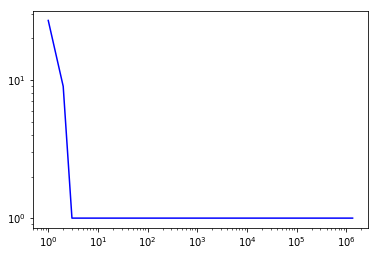

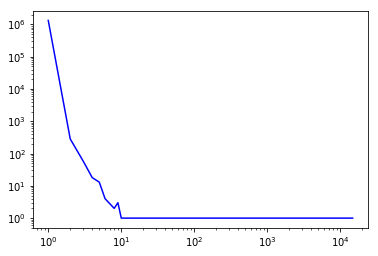

In [67]:
for s_type in cc_sizes.keys():

    # on récupère les valeurs
    d = np.array(sorted(cc_sizes[s_type]))
    
    # on compte les occurences
    nb_occ = np.bincount(d)
    nb_occ = nb_occ[nb_occ > 0]

    # on récupère les valeurs uniques de d
    d = np.unique(d)

    # plot
    plt.loglog(d, nb_occ, color='blue')
    
    # save & show
    plt.savefig(out_path + "{}_connected_components_sizes_distrib_log.pdf".format(s_type))
    plt.show()
    plt.close()

### Custom wedge metric

<center>
$\frac{\sum_{\text{user }i}LF - L \cap F}{\sum_{\text{user }i}LF - L \cap F + \frac{1}{2}(L(L-1) + F(F-1))} = \frac{2\sum_{\text{user }i}LF - L \cap F}{\sum_{\text{user }i}(L+F)^2-L-F-2L \cap F}$
</center>

In [68]:
numerator = 0
denominator = 0

for i in G.nodes:
    leaders = set(G.predecessors(i))
    followers = set(G.successors(i))
    friends = leaders.intersection(followers)
    if len(leaders) + len(followers) < 2:
        continue
    if leaders==followers and len(leaders)==1:
        continue
    L = len(leaders)
    F = len(followers)
    LintF = len(friends)
    numerator += L*F - LintF
    denominator += (L+F)**2 - L - F - 2*LintF

if denominator != 0:
    wedge_metric = 2 * numerator / denominator
else:
    wedge_metric = 0

In [69]:
print("Wedge_metric : ", wedge_metric)
graph_stats.write("Wedge_metric : {}".format(wedge_metric))

Wedge_metric :  0.0006678867139367776


36

### Close graph_stats

In [70]:
graph_stats.close()

# Activity

### Nb tweets/retweets/retweeted stats

On compte le nb de tweets, retweets et retweeted par utilisateur.

In [20]:
count = dict()
count['tweets'], count['retweets'], count['retweeted'], total_time = util.get_activity(
    data_path, RTU, cascade, divide_by_time=False, retweeted=True, Author=Author)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-e6b42e692d46>", line 3, in <module>
    data_path, RTU, cascade, divide_by_time=False, retweeted=True, Author=Author)
  File "D:\PC de Antoine\Documents - data drive\Stage2019\Code\util.py", line 130, in get_activity
    if rtu not in users:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 1095, in get_records
    return

KeyboardInterrupt: 

In [ ]:
count

On affiche et on enregistre.

In [ ]:
%%capture cap

for count_type in count.keys():
    c = np.array([*count[count_type].values()])
    print("----- Stats for {} per user -----".format(count_type))
    print("Total: ", c.sum())
    print("Mean: ", np.mean(c))
    print("Median: ", np.median(c))
    print("Min: ", np.min(c))
    maximum = np.max(c)
    print("Max: {} (user {})".format(maximum, [u for u in count['tweets'] if count[count_type][u]==maximum]))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(c, percent)))
    print("Nb users with at least 1: ", c[c>0].shape[0])
    print("Nb users with 0: ", c[c==0].shape[0])
    print()

In [ ]:
print(cap)
with open(out_path + "tweetsRetweets_stats.txt", 'w') as out:
    out.write(cap.stdout)
out.close()

### Nb tweets/retweets/retweeted distrib

In [ ]:
for count_type in count.keys():
   
    # on récupère les valeurs
    d = np.array(sorted([*count[count_type].values()]))
    
    # on compte les occurences
    nb_occ = np.bincount(d)
    nb_occ = nb_occ[nb_occ > 0]

    # on récupère les valeurs uniques de d
    d = np.unique(d)

    # plot
    plt.loglog(d, nb_occ, color='blue')
    
    # save & show
    plt.savefig(out_path + "number_of_{}_distrib_log.pdf".format(count_type))
    plt.show()
    plt.close()

### $\lambda, \mu, \nu$ stats

In [ ]:
activity = {'lambda': np.array([*count['tweets'].values()]) / total_time, 
            'mu': np.array([*count['retweets'].values()]) / total_time, 
            'nu': np.array([*count['retweeted'].values()]) / total_time}

In [ ]:
%%capture cap

for act_type in activity.keys():
    c = activity[act_type]
    print("----- Stats for {} -----".format(act_type))
    print("Mean: ", np.mean(c))
    print("Median: ", np.median(c))
    print("Min: ", np.min(c))
    maximum = np.max(c)
    print("Max: ", np.max(c))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(c, percent)))
    print("Nb users with >0: ", c[c>0].shape[0])
    print("Nb users with 0: ", c[c==0].shape[0])
    print()

In [ ]:
print(cap)
with open(out_path + "activity_stats.txt", 'w') as out:
    out.write(cap.stdout)
out.close()